[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/030_data_splitting/data_splitting.ipynb)

# Conjuntos de Datos

Hasta ahora hemos presentado la mayoría de conceptos fundamentales necesarios para entender cómo funciona una `red neuronal`, implementando desde cero los algoritmos que necesitamos para el diseño y entrenamiento de estos modelos. Sin embargo, de ahora en adelante utilizaremos la librería de `redes neuronales` [Pytorch](https://pytorch.org/), la cual hemos introducido en los posts anteriores. A pesar de que ya conocemos cómo entrenar modelos simples de `Perceptrón Multicapa` en tareas de regresión y clasificación, es posible que no obtengas los resultados deseados (al menos comparados con resultados que puedes encontrar en otras referencia). En los próximos posts nos vamos a centrar en técnicas concretas que van a permitirnos entrenar los mejores modelos posibles, terminando con una "receta" que podemos utilizar en nuestros proyectos. En este post empezamos viendo técnicas de división de datos necesarias para entrenar y validar nuestras `redes neuronales` de forma correcta.

## Datos de entrenamiento

Vamos a entrenar un `MLP` para clasificación de imágenes con el dataset MNIST, algo que ya hemos hecho en los posts anteriores.

In [1]:
import torch
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Empezamos descargando nuestro dataset. En este primer ejemplo utilizaremos todos los datos disponibles para entrenar nuestra red. Al fin y al cabo, sabemos que cuántos más datos tengamos, mejor será nuestro modelo. Así que, ¿por qué no usarlos todos?

In [2]:
# descarga datos

mnist = fetch_openml('mnist_784', version=1)
X, Y = mnist["data"], mnist["target"]

X_train, y_train = X / 255., Y.astype(np.int)

X_train.shape, y_train.shape

((70000, 784), (70000,))

In [38]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float().cuda()
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]
    
dataset = Dataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

> 💡 Si no estás familiarizado con `Pytorch`, te recomiendo que le eches un vistazo a nuestra [playlist](https://youtu.be/WL50sQVdQFg) para aprender a usar esta librería.

In [39]:
def build_model(D_in=784, H=100, D_out=10):
    model = torch.nn.Sequential(
        torch.nn.Linear(D_in, H),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
    ).to("cuda")
    return model

def fit(model, dataloader, epochs=10, log_each=1):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
    l = []
    model.train()
    for e in range(1, epochs+1): 
        _l = []
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        l.append(np.mean(_l))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l}

In [40]:
model = build_model()
hist = fit(model, dataloader)

Epoch 1/10 loss 0.34560
Epoch 2/10 loss 0.13219
Epoch 3/10 loss 0.09627
Epoch 4/10 loss 0.07519
Epoch 5/10 loss 0.06298
Epoch 6/10 loss 0.05043
Epoch 7/10 loss 0.04378
Epoch 8/10 loss 0.03628
Epoch 9/10 loss 0.03156
Epoch 10/10 loss 0.02635


Muy bien, hemos entrenado nuestro clasificador de imágenes. ¿Cómo sabemos si es bueno? De momento la única información que tenemos es el valor de la función de pérdida, la medida del error que nuestro clasificador comete durante el entrenamiento. Esta valor decrece a medida que pasan las *epochs*, lo cual indica que nuestra `red` está aprendiendo y mejorando. Podemos observar esto la siguiente imágen.

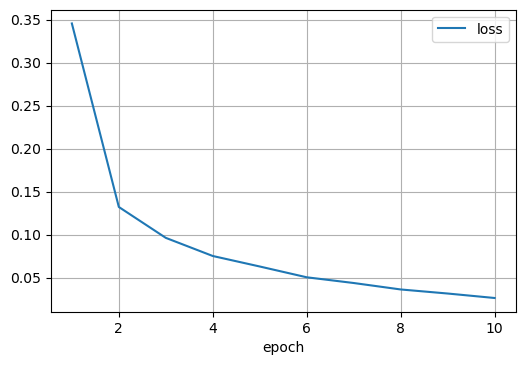

In [41]:
fig = plt.figure(dpi=100)
ax = plt.subplot(111)
pd.DataFrame(hist).plot(x='epoch', grid=True, ax=ax)
plt.show()

El siguiente paso podría ser evaluar diferentes **métricas**. En este [post](https://sensioai.com/blog/016_metricas_clasficiacion) hablamos extendidamente de este tema. La métrica más sencilla que podemos usar para evaluar un clasificador es la precisión (cuántas imágenes nuestro modelo clasifica correctamente). 

In [42]:
from sklearn.metrics import accuracy_score

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum(axis=-1,keepdims=True)

def evaluate(x):
    model.eval()
    y_pred = model(x)
    y_probas = softmax(y_pred)
    return torch.argmax(y_probas, axis=1)

In [43]:
y_pred = evaluate(torch.from_numpy(X_train).float().cuda())
accuracy_score(y_train, y_pred.cpu().numpy())

0.9918

Superamos el $99 \%$ de precisión, ¡nada mal!. Podemos incluir esta métrica en nuestro bucle de entrenamiento para ver su evolución.

In [44]:
def fit(model, dataloader, epochs=10, log_each=1):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
    model.train()
    l, acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        for x_b, y_b in dataloader:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc}

In [45]:
model = build_model()
hist = fit(model, dataloader)

Epoch 1/10 loss 0.34208 acc 0.89296
Epoch 2/10 loss 0.13137 acc 0.95952
Epoch 3/10 loss 0.09799 acc 0.96944
Epoch 4/10 loss 0.07738 acc 0.97626
Epoch 5/10 loss 0.06384 acc 0.98030
Epoch 6/10 loss 0.05172 acc 0.98362
Epoch 7/10 loss 0.04418 acc 0.98546
Epoch 8/10 loss 0.03613 acc 0.98832
Epoch 9/10 loss 0.03176 acc 0.98998
Epoch 10/10 loss 0.02543 acc 0.99240


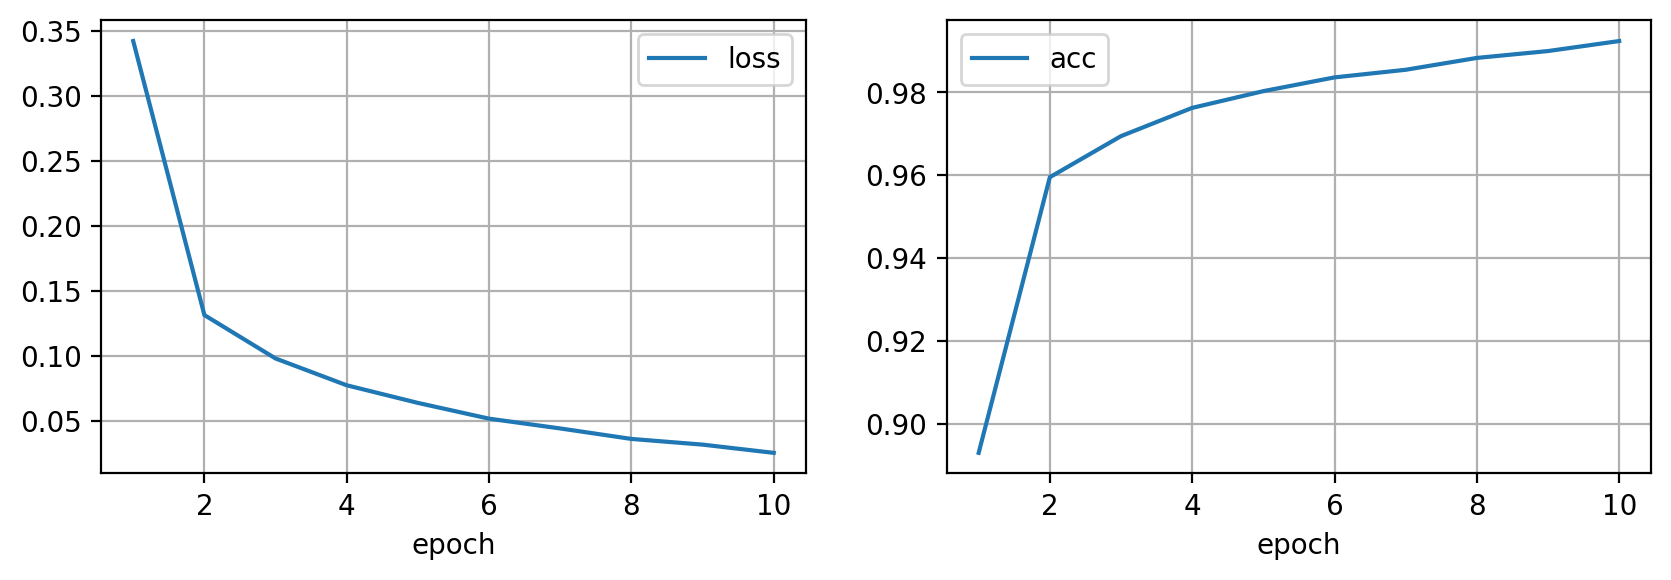

In [46]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y='loss', grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y='acc', grid=True, ax=ax)
plt.show()

Hemos entrenado un clasificador de imágenes que alcanza el $99 \%$ de precisión en los datos utilizados para entrenar, además viendo las curvas de entrenamiento parece que si entrenamos durante más *epochs*, podríamos incluso mejorar este resultado. 

In [47]:
model = build_model()
hist = fit(model, dataloader, epochs=30, log_each=10)

Epoch 10/30 loss 0.01814 acc 0.99470
Epoch 20/30 loss 0.00174 acc 0.99996
Epoch 30/30 loss 0.00082 acc 1.00000


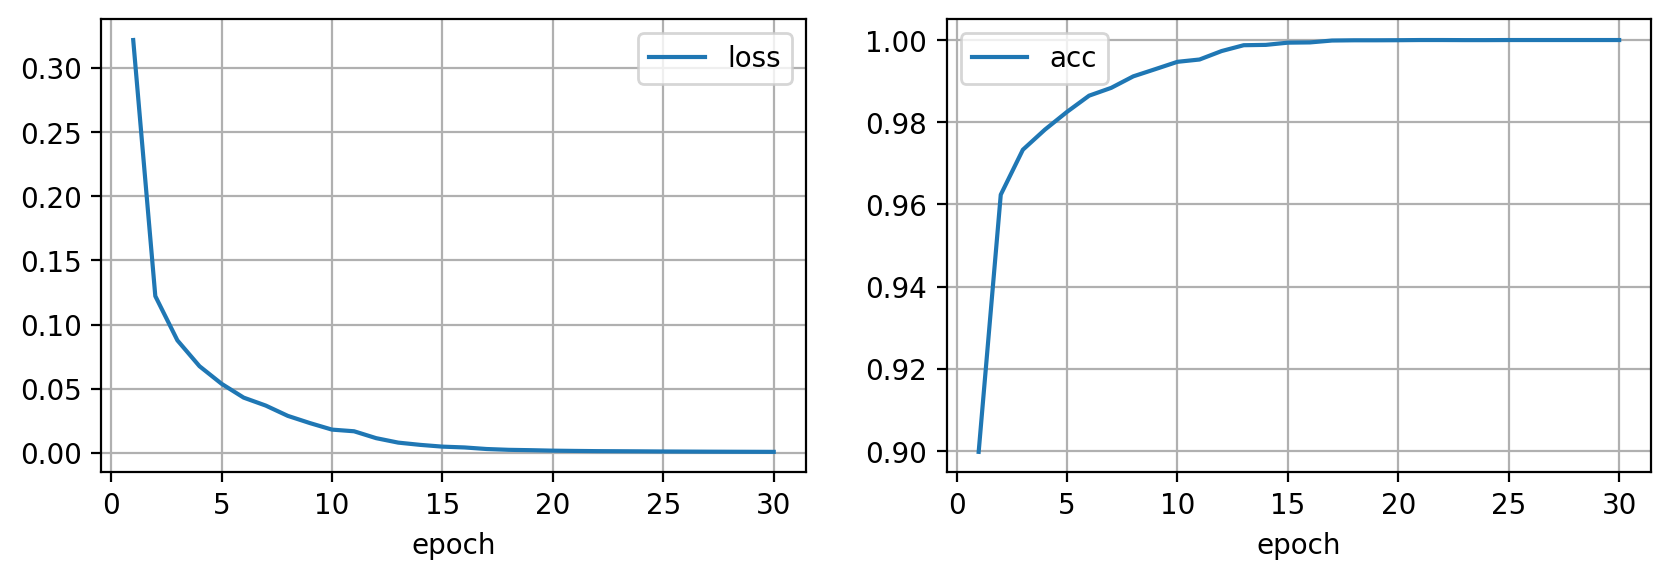

In [48]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y='loss', grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y='acc', grid=True, ax=ax)
plt.show()

Llegamos a alcanzar el $100 \%$ de precisión. Nuestro modelo clasifica correctamente todas la imágenes en el dataset. ¿Es posible que hayamos entrenado el mejor modelo de la historia?. Lamentablemente, la respuesta es NO. El procedimiento que hemos seguido tiene un fallo, y es que cuando este modelo esté trabajando en el mundo real, las imágenes que va a recibir serán diferentes a las utilizadas durante el entrenamiento, y ahora mismo no tenemos ni idea de cómo se va a comportar. Es por esto que necesitamos evaluar nuestro modelo en un conjunto de imágenes que no hayamos usado para entrenar para hacernos una idea de la *performance* de nuestro modelo en el mundo real.

## El conjunto de *test*

Para evaluar un modelo una vez entrenado, usamos el conjunto de datos de *test*. En multitud de ocasiones, este conjunto nos vendrá dado directamente, sobretodo si el dataset con el que trabajamos se utiliza para comparar diferentes modelos en, por ejemplo, una competición o un *benchmark*. Además, este conjunto de datos suele estar oculto y protegido de manera que todos los modelos sean siempre evaluados en el mismo conjunto de datos y, además, en un conjunto de datos que nadie conoce. Esta es la manera más justa de comparar modelos, y la que utilizaremos nosotros para evaluar nuestros modelos una vez entrenados. En nuestro caso, simplemente separaremos un conjunto de imágenes de nuestro dataset.

In [49]:
X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000].astype(np.int), Y[60000:].astype(np.int)

X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Ahora entrenaremos nuestro modelo sólo con las imágenes de entrenamiento, y lo evaluaremos en las imágenes de test.

In [50]:
dataset = Dataset(X_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

In [51]:
model = build_model()
hist = fit(model, dataloader, epochs=30, log_each=10)

Epoch 10/30 loss 0.02553 acc 0.99172
Epoch 20/30 loss 0.00268 acc 0.99973
Epoch 30/30 loss 0.00085 acc 1.00000


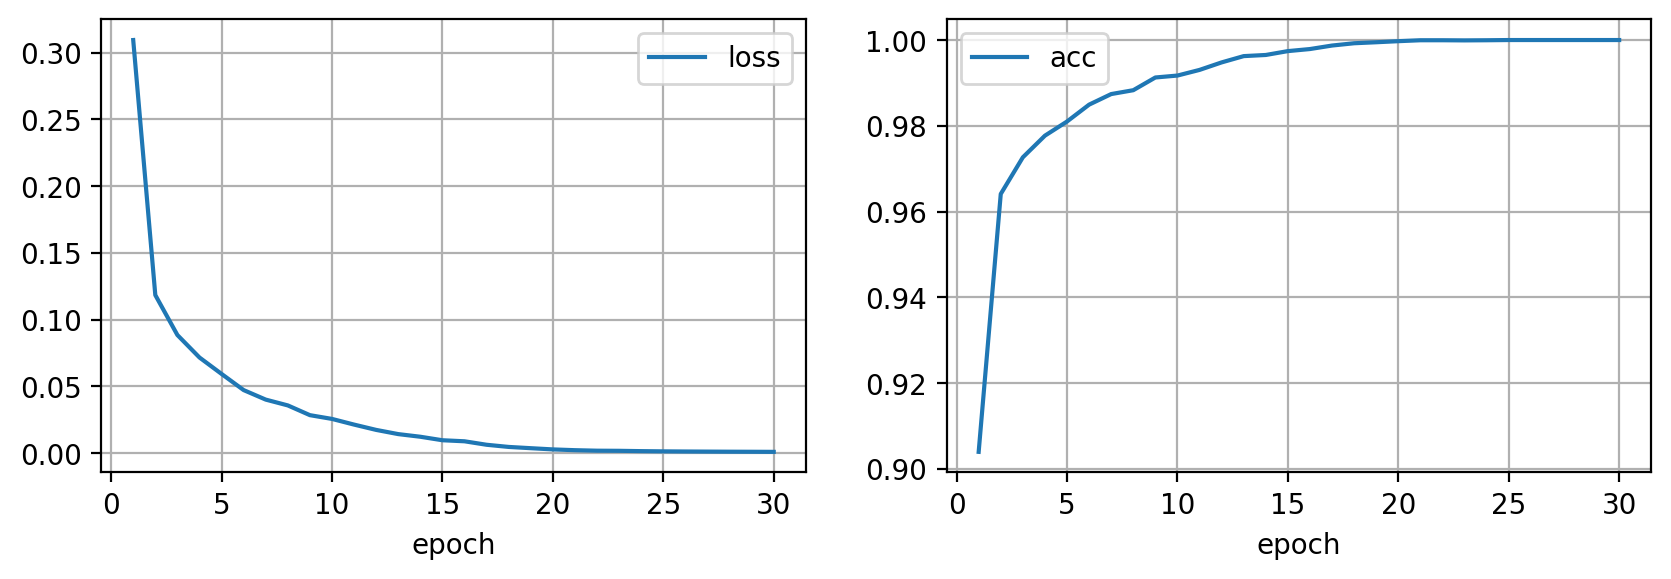

In [52]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y='loss', grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y='acc', grid=True, ax=ax)
plt.show()

In [53]:
y_pred = evaluate(torch.from_numpy(X_test).float().cuda())
accuracy_score(y_test, y_pred.cpu().numpy())

0.9796

Oh oh... Nuestro modelo es perfecto en los datos de entrenamiento, sin embargo al evaluarlo en los datos de *test* (recuerda, datos no usados para entrenar) la precisión se reduce. Este fenómeno se conoce por el nombre de *overfitting*, y se da cuando un modelo se ajusta muy bien a los datos de entrenamiento pero luego falla en datos nuevos, no vistos en el entrenamiento.

## Capacidad

Hablamos de la capacidad de un modelo para referirnos a su potencia a la hora de representar un conjunto de datos.


![](https://i0.wp.com/www.aprendemachinelearning.com/wp-content/uploads/2017/12/generalizacion-machine-learning.png?resize=525%2C211)

Si un modelo tiene poca capacidad, observaremos *underfitting*. El modelo no tiene suficientes parámetros para representar correctamente un dataset y tendremos una mala precisión. 

In [54]:
model = build_model(H=3)
hist = fit(model, dataloader, epochs=30, log_each=10)

Epoch 10/30 loss 1.99228 acc 0.24210
Epoch 20/30 loss 1.96360 acc 0.24925
Epoch 30/30 loss 2.00129 acc 0.23937


Nuestro modelo simple no es capaz de alcanzar la máxima precisión en los datos de entrenamiento, esta es la clara señal de *underfitting* y en este caso simplemente tendremos que aumentar el número de parámetros.

En el caso contrario, si nuestro modelo tiene mucha capacidad (más parámetros de los necesarios) se ajustará muy bien a los datos de entrenamiento pero no será capaz de generalizar a datos nos vistos durante el entrenamiento. Esto es lo que llamamos *overfitting*, y es el fenómeno que estamos observando en nuestro ejemplo. Nuestro objetivo será encontrar un modelo con la capacidad "correcta", algo de lo que hablaremos en futuros posts.

En este punto, podrías estar tentado a probar diferentes arquitecturas, modificando el número de capas del `MLP` por ejemplo, y utilizar la mejor combinación de parámetros que maximice la métrica en el conjunto de test. Sin embargo, esta aproximación no es la correcta ya que lo único que conseguiriamos sería hacer *overfitting* al conjunto de test. Es por esto que utilizamos los datos de *test* para evaluar nuestro modelo, y para elegir el mejor modelo utilizamos un tercer conjunto de datos.

## El conjunto de *validación*.

El conjunto de datos de validación nos servirá para iterar nuestro modelo, probar varias versiones para encontrar aquella con mejor capacidad que, últimamente, evaluaremos con los datos de test. Si tanto el conjunto de test como el de evaluación son representativos, podemos confiar que las métricas obtenidas en validación se transferirán a test.

In [55]:
X_train, X_val, X_test = X[:50000] / 255., X[50000:60000] / 255., X[60000:] / 255.
y_train, y_val, y_test = Y[:50000].astype(np.int), Y[50000:60000].astype(np.int), Y[60000:].astype(np.int)

X_train.shape, X_val.shape, X_test.shape

((50000, 784), (10000, 784), (10000, 784))

In [56]:
dataset = {
    'train': Dataset(X_train, y_train),
    'val': Dataset(X_val, y_val)
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
}

In [57]:
def fit(model, dataloader, epochs=10, log_each=1):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.8)
    l, acc = [], []
    val_l, val_acc = [], []
    for e in range(1, epochs+1): 
        _l, _acc = [], []
        model.train()
        for x_b, y_b in dataloader['train']:
            y_pred = model(x_b)
            loss = criterion(y_pred, y_b)
            _l.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_probas = torch.argmax(softmax(y_pred), axis=1)            
            _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().detach().numpy()))
        l.append(np.mean(_l))
        acc.append(np.mean(_acc))
        model.eval()
        _l, _acc = [], []
        with torch.no_grad():
            for x_b, y_b in dataloader['val']:
                y_pred = model(x_b)
                loss = criterion(y_pred, y_b)
                _l.append(loss.item())
                y_probas = torch.argmax(softmax(y_pred), axis=1)            
                _acc.append(accuracy_score(y_b.cpu().numpy(), y_probas.cpu().numpy()))
        val_l.append(np.mean(_l))
        val_acc.append(np.mean(_acc))
        if not e % log_each:
            print(f"Epoch {e}/{epochs} loss {l[-1]:.5f} acc {acc[-1]:.5f} val_loss {val_l[-1]:.5f} val_acc {val_acc[-1]:.5f}")
    return {'epoch': list(range(1, epochs+1)), 'loss': l, 'acc': acc, 'val_loss': val_l, 'val_acc': val_acc}

In [58]:
model = build_model()
hist = fit(model, dataloader, epochs=30, log_each=10)

Epoch 10/30 loss 0.02478 acc 0.99246 val_loss 0.09078 val_acc 0.97580
Epoch 20/30 loss 0.00232 acc 0.99988 val_loss 0.09484 val_acc 0.97780
Epoch 30/30 loss 0.00092 acc 1.00000 val_loss 0.10228 val_acc 0.97720


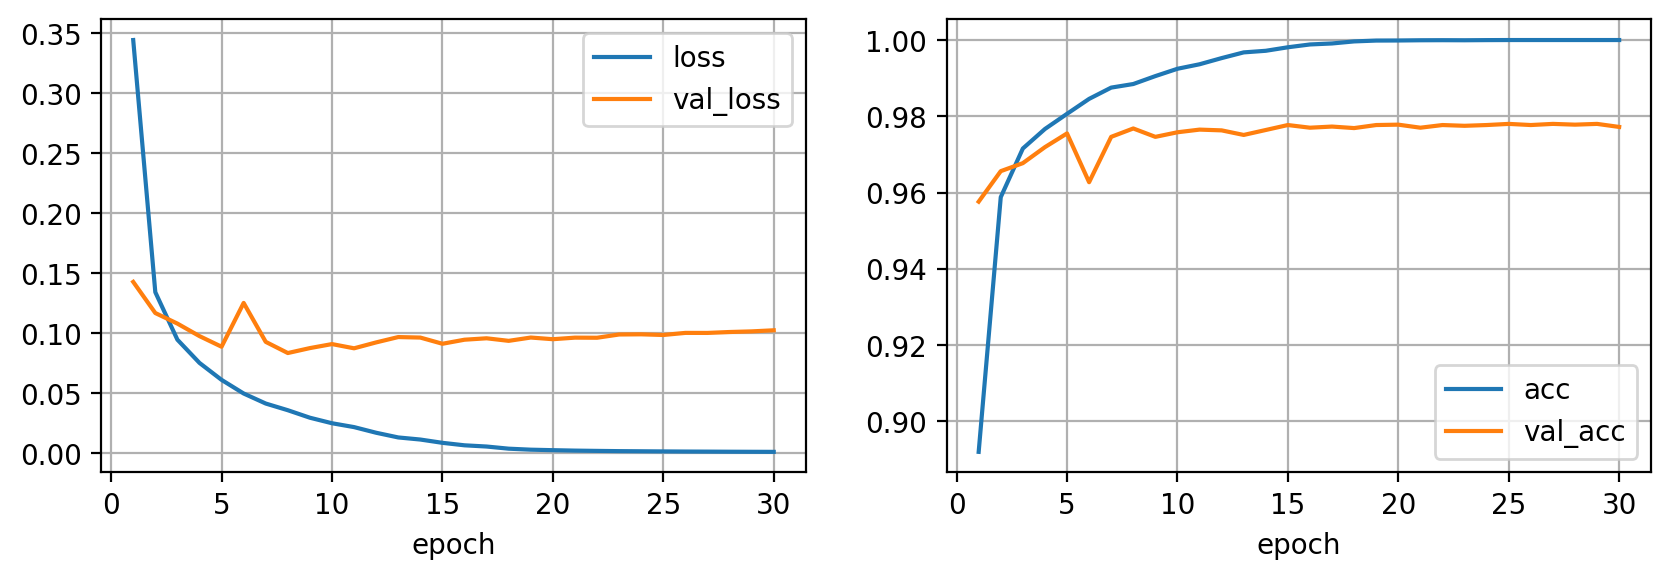

In [59]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
pd.DataFrame(hist).plot(x='epoch', y=['loss', 'val_loss'], grid=True, ax=ax)
ax = plt.subplot(122)
pd.DataFrame(hist).plot(x='epoch', y=['acc', 'val_acc'], grid=True, ax=ax)
plt.show()

Como puedes observar en las curvas de entrenamiento, la *loss* de entrenamiento disminuye mientras la precisión aumenta hasta llegar al valor máximo. Sin embargo, si observamos las métricas de validación, éstas se estancan en el valor que hemos obtenido antes al evaluar nuestro modelo en los datos de test. Esta es la señal clara de que nuestro modelos está haciendo *overfitting* a los datos de entrenamiento, lo cual implica que no será capaz de generalizar bien a nuevos datos. 

![](https://qph.fs.quoracdn.net/main-qimg-ad7d9595f354c89dc3d9245de5b1ebf6.webp)

Será pues el objetivo de los próximos posts ver cómo tratamos con el *overfitting* para intentar reducir al máximo su impacto, ya que cómo hemos visto si no hacemos nada nuestros modelos tenderán a hacer *overfitting* (este es el sino de las `redes neuronales`).

## Validación cruzada

Hemos visto que para evaluar correctamente un modelo necesitamos un conjunto de datos de *test*. Además para poder iterar diferentes versiones de un modelo, necesitamos un conjunto de *validación*. Este es el procedimiento más utilizado cuando trabajamos con modelos o datasets muy grandes que requieren muchos recursos computacionales. Sin embargo existe una mejor aproximación que, si nos la podemos permitir, nos dará muchos mejores resultados: la validación cruzada.

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

Esta técnica consiste en dividir nuestro conjunto de datos de entrenamiento en diferentes paquetes, o *folds* en inglés, y entrenar tantos modelos como *folds* tengamos, utilizando un *fold* diferente para validar en cada caso y entrenando con el resto de *folds*. De esta manera, habremos entrenado y validado con todos los datos de entrenamiento. Esta técnica permite, además, utilizar todos los modelos entrenados para generar las predicciones finales en los que se conoce como un ensamblado de modelos. La idea es que las predicciones generadas por este ensamblado serán mejores que cualquier predicción hecha por un modelo individual, ya que las debilidades de un modelo serán compensadas por el resto. Esta técnica es muy utilizada en competiciones para sacar ese extra de precisión final que puede marcar la diferencia.

In [60]:
from sklearn.model_selection import KFold

FOLDS = 5
kf = KFold(n_splits=FOLDS)

X_train, X_test, y_train, y_test = X[:60000] / 255., X[60000:] / 255., Y[:60000].astype(np.int), Y[60000:].astype(np.int)

X_train.shape, X_test.shape, kf.get_n_splits(X)

((60000, 784), (10000, 784), 5)

In [61]:
train_accs, val_accs = [], []
for k, (train_index, val_index) in enumerate(kf.split(X_test)):
    print("Fold:", k+1)
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    dataset = {
        'train': Dataset(X_train_fold, y_train_fold),
        'val': Dataset(X_val_fold, y_val_fold)
    }

    dataloader = {
        'train': torch.utils.data.DataLoader(dataset['train'], batch_size=100, shuffle=True),
        'val': torch.utils.data.DataLoader(dataset['val'], batch_size=1000, shuffle=False)
    }
    
    model = build_model()
    hist = fit(model, dataloader)
    
    train_accs.append(hist['acc'][-1])   
    val_accs.append(hist['val_acc'][-1])

Fold: 1
Epoch 1/10 loss 0.82165 acc 0.74062 val_loss 0.71121 val_acc 0.77150
Epoch 2/10 loss 0.28030 acc 0.91862 val_loss 0.28827 val_acc 0.91450
Epoch 3/10 loss 0.18365 acc 0.94400 val_loss 0.22622 val_acc 0.93350
Epoch 4/10 loss 0.14354 acc 0.95625 val_loss 0.21090 val_acc 0.93300
Epoch 5/10 loss 0.10772 acc 0.96700 val_loss 0.21574 val_acc 0.93900
Epoch 6/10 loss 0.08594 acc 0.97475 val_loss 0.19277 val_acc 0.94250
Epoch 7/10 loss 0.06680 acc 0.98000 val_loss 0.19674 val_acc 0.94600
Epoch 8/10 loss 0.04934 acc 0.98625 val_loss 0.19461 val_acc 0.94050
Epoch 9/10 loss 0.03874 acc 0.99050 val_loss 0.18955 val_acc 0.94450
Epoch 10/10 loss 0.03099 acc 0.99300 val_loss 0.19006 val_acc 0.94700
Fold: 2
Epoch 1/10 loss 0.82244 acc 0.73112 val_loss 0.40342 val_acc 0.86500
Epoch 2/10 loss 0.29770 acc 0.90888 val_loss 0.24407 val_acc 0.92950
Epoch 3/10 loss 0.19692 acc 0.94187 val_loss 0.19395 val_acc 0.94350
Epoch 4/10 loss 0.15028 acc 0.95513 val_loss 0.20939 val_acc 0.93950
Epoch 5/10 loss 0

Hacer validación cruzada nos permite dar un intervalo de confianza en las métricas, lo cual nos permite conocer cómo de seguro está nuestro modelo en sus predicciones (información que podemos tener en cuenta a la hora de escoger un modelo sobre otro).

In [64]:
np.mean(train_accs), np.std(train_accs)

(0.992125, 0.0013086252328302042)

In [65]:
np.mean(val_accs), np.std(val_accs)

(0.9509000000000001, 0.005607138307550465)

## Resumen 

En este post hemos visto como tratar nuestros datos para entrenar un modelo de manera correcta. Esto incluye utilizar un conjunto de validación para iterar nuestro modelo y encontrar su capacidad "correcta" y un conjunto de test para evaluar nuestro modelo final. Ambos conjuntos no son utilizados durante el entrenamiento. También hemos hablado de la capacidad de un modelo, que puede dar como resultado los fenómenos de *underfitting* u *overfitting* dependiendo si la `red neurona` tiene poco parámetros o demasiados para representar nuestros datos, respectivamente. La aproximación más común a este problema es la de sobreparametrizar nuestro modelo y luego aplicar técnicas de las cuales hablaremos más adelante para intentar reducir al máximo el *overfitting*. Por último, también hemos hablado sobre la validación cruzada, una técnica de validación muy interesante que debemos aplicar siempre que podemos permitírnoslo y que también nos permite utilizar varios modelos en un ensamblado para mejorar las métricas finales.